In [17]:
%reload_ext autoreload

# Data Splitting Tutorial for Stock Market Analytics

This notebook demonstrates how to use the data splitting capabilities in `preprocessors.py` for time-series panel data with proper leakage prevention.

## Overview

The main components are:
1. **PanelHorizonSplitter**: Creates Train/Val/Cal/Test splits with embargo periods
2. **PurgedTimeSeriesSplit**: Cross-validation splitter for hyperparameter optimization

Both classes handle:
- **Time-series leakage prevention**: Future information doesn't leak into training
- **Embargo periods**: Buffer zones around test periods to prevent label overlap
- **Panel data structure**: Multiple symbols across time

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our data splitting classes
from stock_market_analytics.modeling.model_factory.data_management.preprocessors import (
    PanelHorizonSplitter,
    PurgedTimeSeriesSplit
)

## 1. Creating Sample Panel Data

Let's create a synthetic dataset that mimics stock market panel data:

In [19]:
# Create sample panel data
np.random.seed(42)

# Date range: 2 years of daily data
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-12-31')
dates = pd.date_range(start_date, end_date, freq='D')

# Multiple symbols
symbols = ['AAPL', 'GOOGL', 'MSFT', 'TSLA', 'AMZN']

# Create panel structure
data_list = []
for symbol in symbols:
    for date in dates:
        # Skip weekends (simulate market days)
        if date.weekday() < 5:  # Monday = 0, Sunday = 6
            data_list.append({
                'date': date,
                'symbol': symbol,
                'feature1': np.random.randn(),
                'feature2': np.random.randn(),
                'feature3': np.random.randn(),
                'target': np.random.randn()  # 5-day forward return
            })

df = pd.DataFrame(data_list)
print(f"Created dataset with {len(df)} rows")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Symbols: {df['symbol'].unique()}")
print(f"Unique dates: {df['date'].nunique()}")
df.head(10)

Created dataset with 2600 rows
Date range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00
Symbols: ['AAPL' 'GOOGL' 'MSFT' 'TSLA' 'AMZN']
Unique dates: 520


,date,symbol,feature1,feature2,feature3,target
0,2022-01-03,AAPL,0.496714,-0.138264,0.647689,1.523030
1,2022-01-04,AAPL,-0.234153,-0.234137,1.579213,0.767435
2,2022-01-05,AAPL,-0.469474,0.542560,-0.463418,-0.465730
3,2022-01-06,AAPL,0.241962,-1.913280,-1.724918,-0.562288
4,2022-01-07,AAPL,-1.012831,0.314247,-0.908024,-1.412304
5,2022-01-10,AAPL,1.465649,-0.225776,0.067528,-1.424748
6,2022-01-11,AAPL,-0.544383,0.110923,-1.150994,0.375698
7,2022-01-12,AAPL,-0.600639,-0.291694,-0.601707,1.852278
8,2022-01-13,AAPL,-0.013497,-1.057711,0.822545,-1.220844
9,2022-01-14,AAPL,0.208864,-1.959670,-1.328186,0.196861


## 2. Basic Data Splitting with PanelHorizonSplitter

The `PanelHorizonSplitter` creates four splits:
- **Train**: For model training
- **Val**: For early stopping and validation
- **Cal**: For calibration (e.g., conformal prediction)
- **Test**: For final evaluation

In [20]:
# Initialize the splitter
splitter = PanelHorizonSplitter(
    date_col='date',
    symbol_col='symbol',
    horizon_days=5,  # 5-day prediction horizon
    embargo_days=5   # 5-day embargo period
)

# Create holdout splits using default fractions (70/10/10/10)
split_indices = splitter.make_holdout_splits(
    df,
    fractions=(0.7, 0.1, 0.1, 0.1),
    return_frames=False  # Return indices instead of DataFrames
)

print("Split sizes:")
for split_name, indices in split_indices.items():
    print(f"  {split_name}: {len(indices)} samples")

print(f"\nTotal samples: {sum(len(idx) for idx in split_indices.values())}")
print(f"Original dataset: {len(df)} samples")

Split sizes:
  train_idx: 1785 samples
  val_idx: 255 samples
  cal_idx: 225 samples
  test_idx: 265 samples

Total samples: 2530
Original dataset: 2600 samples


## 3. Visualizing the Splits

Let's visualize how the data is split across time:

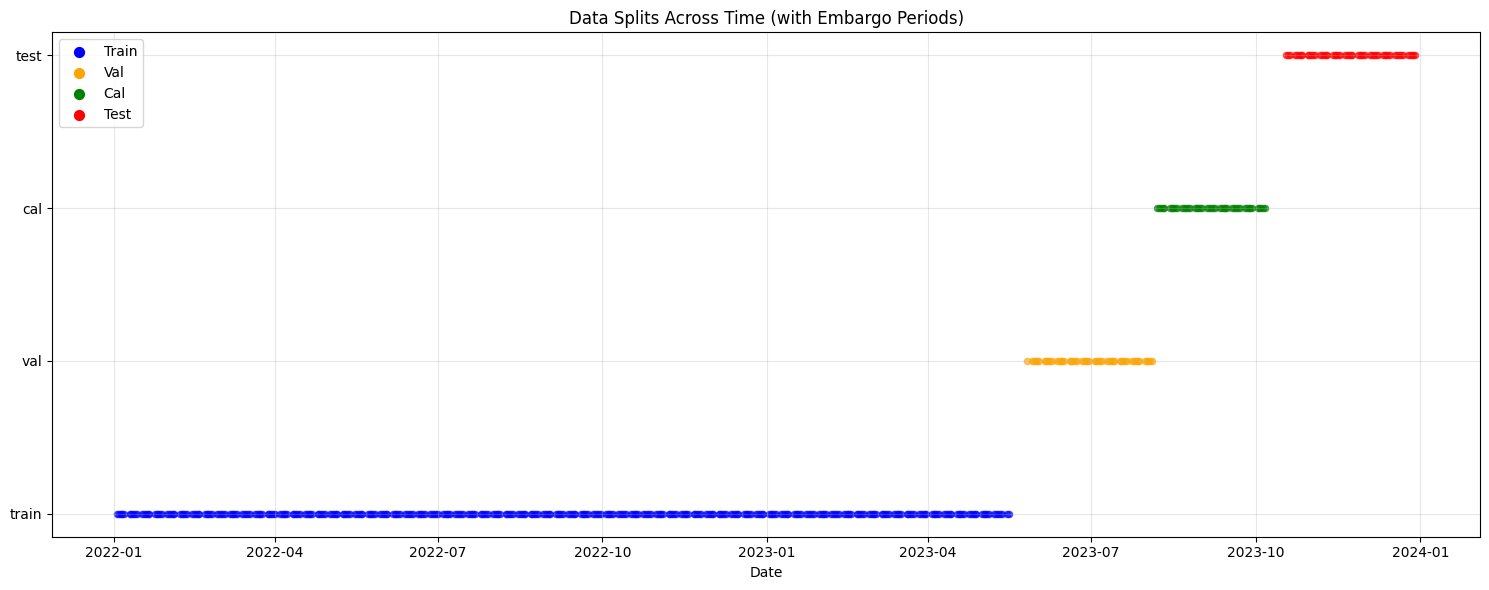


Date ranges for each split:
  Train: 2022-01-03 to 2023-05-16
  Val: 2023-05-26 to 2023-08-04
  Cal: 2023-08-07 to 2023-10-06
  Test: 2023-10-18 to 2023-12-29


In [21]:
# Get the actual DataFrames for visualization
split_frames = splitter.make_holdout_splits(
    df,
    fractions=(0.7, 0.1, 0.1, 0.1),
    return_frames=True
)

# Create visualization
fig, ax = plt.subplots(figsize=(15, 6))

colors = {'train': 'blue', 'val': 'orange', 'cal': 'green', 'test': 'red'}
y_positions = {'train': 0, 'val': 1, 'cal': 2, 'test': 3}

for split_name, split_df in split_frames.items():
    dates = split_df['date'].unique()
    y_pos = y_positions[split_name]
    
    # Plot date ranges as horizontal bars
    for date in dates:
        ax.scatter(date, y_pos, c=colors[split_name], alpha=0.6, s=20)

ax.set_yticks(list(y_positions.values()))
ax.set_yticklabels(list(y_positions.keys()))
ax.set_xlabel('Date')
ax.set_title('Data Splits Across Time (with Embargo Periods)')
ax.grid(True, alpha=0.3)

# Add legend
for split_name, color in colors.items():
    ax.scatter([], [], c=color, label=split_name.capitalize(), s=50)
ax.legend()

plt.tight_layout()
plt.show()

# Print date ranges for each split
print("\nDate ranges for each split:")
for split_name, split_df in split_frames.items():
    min_date = split_df['date'].min()
    max_date = split_df['date'].max()
    print(f"  {split_name.capitalize()}: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")

## 4. Sanity Checks on Split Data

Let's perform comprehensive sanity checks to ensure our splits are valid:

In [22]:
def perform_split_sanity_checks(df, split_indices, split_frames, horizon_days=5, embargo_days=5):
    """Comprehensive sanity checks for data splits."""
    
    print("=" * 50)
    print("SANITY CHECKS FOR DATA SPLITS")
    print("=" * 50)
    
    # Check 1: No overlapping indices
    print("\n1. Checking for overlapping indices...")
    all_indices = set()
    overlap_found = False
    
    for split_name, indices in split_indices.items():
        current_set = set(indices)
        overlap = all_indices.intersection(current_set)
        if overlap:
            print(f"   ❌ OVERLAP FOUND: {split_name} shares {len(overlap)} indices with previous splits")
            overlap_found = True
        all_indices.update(current_set)
    
    if not overlap_found:
        print("   ✅ No overlapping indices found")
    
    # Check 2: All original indices are present
    print("\n2. Checking index coverage...")
    total_split_indices = len(all_indices)
    original_indices = len(df)
    
    if total_split_indices == original_indices:
        print(f"   ✅ All {original_indices} indices are covered")
    else:
        missing = original_indices - total_split_indices
        print(f"   ❌ Missing {missing} indices ({total_split_indices}/{original_indices} covered)")
    
    # Check 3: Temporal ordering
    print("\n3. Checking temporal ordering...")
    split_order = ['train', 'val', 'cal', 'test']
    prev_max_date = None
    ordering_correct = True
    
    for split_name in split_order:
        if split_name not in split_frames:
            continue
            
        split_df = split_frames[split_name]
        min_date = split_df['date'].min()
        max_date = split_df['date'].max()
        
        if prev_max_date is not None and min_date < prev_max_date:
            print(f"   ❌ Temporal overlap: {split_name} starts before previous split ends")
            print(f"      Previous max: {prev_max_date}, Current min: {min_date}")
            ordering_correct = False
        
        prev_max_date = max_date
    
    if ordering_correct:
        print("   ✅ Temporal ordering is correct")
    
    # Check 4: Embargo period validation
    print(f"\n4. Checking embargo periods (horizon={horizon_days}, embargo={embargo_days} days)...")
    embargo_violations = []
    
    for i, current_split in enumerate(split_order[:-1]):
        if current_split not in split_frames:
            continue
            
        next_split = split_order[i + 1]
        if next_split not in split_frames:
            continue
            
        current_max = split_frames[current_split]['date'].max()
        next_min = split_frames[next_split]['date'].min()
        
        # Calculate expected gap (should be at least embargo_days)
        actual_gap = (next_min - current_max).days
        expected_gap = embargo_days
        
        if actual_gap < expected_gap:
            embargo_violations.append(f"{current_split}->{next_split}: {actual_gap} days (expected >={expected_gap})")
    
    if embargo_violations:
        print("   ⚠️  Potential embargo violations:")
        for violation in embargo_violations:
            print(f"      {violation}")
    else:
        print("   ✅ Embargo periods are adequate")
    
    # Check 5: Symbol distribution
    print("\n5. Checking symbol distribution...")
    original_symbols = set(df['symbol'].unique())
    
    for split_name, split_df in split_frames.items():
        split_symbols = set(split_df['symbol'].unique())
        missing_symbols = original_symbols - split_symbols
        
        if missing_symbols:
            print(f"   ⚠️  {split_name.capitalize()} missing symbols: {missing_symbols}")
        else:
            print(f"   ✅ {split_name.capitalize()} has all symbols")
    
    # Check 6: Data balance
    print("\n6. Checking data balance...")
    for split_name, split_df in split_frames.items():
        symbol_counts = split_df['symbol'].value_counts()
        min_count = symbol_counts.min()
        max_count = symbol_counts.max()
        balance_ratio = min_count / max_count if max_count > 0 else 0
        
        print(f"   {split_name.capitalize()}: {min_count}-{max_count} samples per symbol (balance: {balance_ratio:.2f})")
    
    print("\n" + "=" * 50)
    print("SANITY CHECKS COMPLETED")
    print("=" * 50)

# Run the sanity checks
perform_split_sanity_checks(df, split_indices, split_frames, 
                          horizon_days=splitter.horizon_days, 
                          embargo_days=splitter.embargo_days)

SANITY CHECKS FOR DATA SPLITS

1. Checking for overlapping indices...
   ✅ No overlapping indices found

2. Checking index coverage...
   ❌ Missing 70 indices (2530/2600 covered)

3. Checking temporal ordering...
   ✅ Temporal ordering is correct

4. Checking embargo periods (horizon=5, embargo=5 days)...
   ⚠️  Potential embargo violations:
      val->cal: 3 days (expected >=5)

5. Checking symbol distribution...
   ✅ Train has all symbols
   ✅ Val has all symbols
   ✅ Cal has all symbols
   ✅ Test has all symbols

6. Checking data balance...
   Train: 357-357 samples per symbol (balance: 1.00)
   Val: 51-51 samples per symbol (balance: 1.00)
   Cal: 45-45 samples per symbol (balance: 1.00)
   Test: 53-53 samples per symbol (balance: 1.00)

SANITY CHECKS COMPLETED


## 5. Using Different Split Configurations

Let's explore different ways to split the data:

In [23]:
# Configuration 1: Different fractions
print("Configuration 1: Different fractions (60/15/15/10)")
split1 = splitter.make_holdout_splits(df, fractions=(0.6, 0.15, 0.15, 0.1), return_frames=True)
for split_name, split_df in split1.items():
    print(f"  {split_name}: {len(split_df)} samples ({len(split_df)/len(df)*100:.1f}%)")

print("\n" + "-" * 40)

# Configuration 2: Custom cut dates
print("Configuration 2: Custom cut dates")
train_end = pd.Timestamp('2022-08-31')
val_end = pd.Timestamp('2022-11-30')
cal_end = pd.Timestamp('2023-02-28')

split2 = splitter.make_holdout_splits(
    df, 
    cut_dates=(train_end, val_end, cal_end), 
    return_frames=True
)

for split_name, split_df in split2.items():
    min_date = split_df['date'].min()
    max_date = split_df['date'].max()
    print(f"  {split_name}: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')} ({len(split_df)} samples)")

Configuration 1: Different fractions (60/15/15/10)
  train: 1525 samples (58.7%)
  val: 390 samples (15.0%)
  cal: 355 samples (13.7%)
  test: 260 samples (10.0%)

----------------------------------------
Configuration 2: Custom cut dates
  train: 2022-01-03 to 2022-08-22 (830 samples)
  val: 2022-09-01 to 2022-11-30 (325 samples)
  cal: 2022-12-01 to 2023-02-17 (285 samples)
  test: 2023-03-01 to 2023-12-29 (1090 samples)


## 6. CatBoost Integration

The splitter provides a convenient method for CatBoost training:

In [24]:
# Define feature and target columns
feature_cols = ['feature1', 'feature2', 'feature3']
target_col = 'target'

# Get CatBoost-ready datasets
catboost_sets = splitter.catboost_early_stopping_sets(
    df,
    feature_cols=feature_cols,
    target_col=target_col,
    fractions=(0.7, 0.1, 0.1, 0.1)
)

print("CatBoost dataset shapes:")
for set_name, (X, y) in catboost_sets.items():
    print(f"  {set_name}: X={X.shape}, y={y.shape}")

# Example: Access training data
X_train, y_train = catboost_sets['train']
X_val, y_val = catboost_sets['val']

print(f"\nTraining features preview:")
print(X_train.head())
print(f"\nTraining target preview:")
print(y_train.head())

CatBoost dataset shapes:
  train: X=(1785, 3), y=(1785,)
  val: X=(255, 3), y=(255,)
  cal: X=(225, 3), y=(225,)
  test: X=(265, 3), y=(265,)

Training features preview:
   feature1  feature2  feature3
0  0.496714 -0.138264  0.647689
1 -2.010217 -1.323951  1.807631
2  0.000528  0.601207 -1.443855
3  0.012829  0.479827 -0.268646
4 -0.216523 -0.939242  1.332551

Training target preview:
0    1.523030
1    1.641429
2   -2.296181
3   -1.836360
4    0.928932
Name: target, dtype: float64


## 7. Cross-Validation with PurgedTimeSeriesSplit

For hyperparameter optimization, use the purged time series cross-validation:

In [25]:
# Get CV splitter
cv_splitter = splitter.cv_splitter(
    df,
    n_splits=5,
    test_span_days=30  # Each test fold spans 30 days
)

print("Cross-validation folds:")
for i, (train_idx, test_idx) in enumerate(cv_splitter.split(df)):
    train_dates = df.iloc[train_idx]['date']
    test_dates = df.iloc[test_idx]['date']
    
    print(f"  Fold {i+1}:")
    print(f"    Train: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')} ({len(train_idx)} samples)")
    print(f"    Test:  {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')} ({len(test_idx)} samples)")
    
    # Check for leakage
    if train_dates.max() >= test_dates.min():
        print(f"    ❌ LEAKAGE DETECTED: Train max >= Test min")
    else:
        gap = (test_dates.min() - train_dates.max()).days
        print(f"    ✅ No leakage: {gap} day gap")

Cross-validation folds:
  Fold 1:
    Train: 2022-01-03 to 2023-12-29 (610 samples)
    Test:  2022-06-27 to 2022-11-18 (105 samples)
    ❌ LEAKAGE DETECTED: Train max >= Test min
  Fold 2:
    Train: 2022-01-03 to 2023-12-29 (1260 samples)
    Test:  2022-12-26 to 2023-05-19 (105 samples)
    ❌ LEAKAGE DETECTED: Train max >= Test min
  Fold 3:
    Train: 2022-01-03 to 2023-12-29 (1910 samples)
    Test:  2023-06-26 to 2023-11-17 (105 samples)
    ❌ LEAKAGE DETECTED: Train max >= Test min
  Fold 4:
    Train: 2022-01-03 to 2023-12-29 (2560 samples)
    Test:  2023-12-25 to 2023-12-29 (5 samples)
    ❌ LEAKAGE DETECTED: Train max >= Test min


In [26]:
def assert_no_label_overlap(df, train_idx, test_idx, horizon=5, embargo=None):
    if embargo is None: embargo = horizon
    tr_dates = pd.to_datetime(df.iloc[train_idx]['date']).to_numpy('datetime64[D]')
    te_dates = pd.to_datetime(df.iloc[test_idx]['date']).to_numpy('datetime64[D]')
    tr_end = tr_dates + np.timedelta64(horizon, 'D')
    union_start = te_dates.min() - np.timedelta64(embargo, 'D')
    union_end   = te_dates.max() + np.timedelta64(horizon + embargo, 'D')
    # No train interval [t, t+h) may overlap [union_start, union_end]
    overlap = (tr_dates < union_end) & (tr_end > union_start)
    assert not overlap.any(), "Label-window overlap detected!"

# Validate no label leakage in CV folds
for i, (train_idx, test_idx) in enumerate(cv_splitter.split(df)):
    try:
        assert_no_label_overlap(df, train_idx, test_idx, horizon=splitter.horizon_days, embargo=splitter.embargo_days)
        print(f"Fold {i+1}: ✅ No label leakage detected")
    except AssertionError as e:
        print(f"Fold {i+1}: ❌ {str(e)}")

Fold 1: ❌ Label-window overlap detected!
Fold 2: ❌ Label-window overlap detected!
Fold 3: ❌ Label-window overlap detected!
Fold 4: ❌ Label-window overlap detected!


## 8. Advanced Sanity Checks for Cross-Validation

Let's perform additional checks specifically for the CV splitter:

In [12]:
def check_cv_splits(df, cv_splitter, horizon_days=5, embargo_days=5):
    """Comprehensive checks for cross-validation splits."""
    
    print("=" * 50)
    print("CV SPLIT SANITY CHECKS")
    print("=" * 50)
    
    splits = list(cv_splitter.split(df))
    
    # Check 1: No train-test overlap in each fold
    print("\n1. Checking train-test overlap in each fold...")
    overlap_found = False
    
    for i, (train_idx, test_idx) in enumerate(splits):
        overlap = set(train_idx).intersection(set(test_idx))
        if overlap:
            print(f"   ❌ Fold {i+1}: {len(overlap)} overlapping samples")
            overlap_found = True
    
    if not overlap_found:
        print("   ✅ No train-test overlap in any fold")
    
    # Check 2: Temporal separation (purging check)
    print(f"\n2. Checking temporal separation (horizon={horizon_days}, embargo={embargo_days})...")
    purge_violations = []
    
    for i, (train_idx, test_idx) in enumerate(splits):
        train_dates = df.iloc[train_idx]['date']
        test_dates = df.iloc[test_idx]['date']
        
        train_max = train_dates.max()
        test_min = test_dates.min()
        
        # Check if there's adequate separation
        gap = (test_min - train_max).days
        min_gap = embargo_days  # Should be at least embargo days
        
        if gap < min_gap:
            purge_violations.append(f"Fold {i+1}: {gap} days gap (expected >={min_gap})")
    
    if purge_violations:
        print("   ⚠️  Potential purging violations:")
        for violation in purge_violations:
            print(f"      {violation}")
    else:
        print("   ✅ All folds have adequate temporal separation")
    
    # Check 3: Test fold coverage
    print("\n3. Checking test fold coverage...")
    all_test_indices = set()
    for train_idx, test_idx in splits:
        all_test_indices.update(test_idx)
    
    coverage_ratio = len(all_test_indices) / len(df)
    print(f"   Test coverage: {len(all_test_indices)}/{len(df)} samples ({coverage_ratio:.1%})")
    
    # Check 4: Fold balance
    print("\n4. Checking fold balance...")
    test_sizes = [len(test_idx) for _, test_idx in splits]
    min_size, max_size = min(test_sizes), max(test_sizes)
    balance_ratio = min_size / max_size if max_size > 0 else 0
    
    print(f"   Test fold sizes: {min_size} to {max_size} samples (balance: {balance_ratio:.2f})")
    
    if balance_ratio > 0.8:
        print("   ✅ Folds are well balanced")
    else:
        print("   ⚠️  Folds are imbalanced")
    
    print("\n" + "=" * 50)
    print("CV CHECKS COMPLETED")
    print("=" * 50)

# Run CV sanity checks
check_cv_splits(df, cv_splitter, 
               horizon_days=splitter.horizon_days, 
               embargo_days=splitter.embargo_days)

CV SPLIT SANITY CHECKS

1. Checking train-test overlap in each fold...
   ✅ No train-test overlap in any fold

2. Checking temporal separation (horizon=5, embargo=5)...
   ⚠️  Potential purging violations:
      Fold 1: -550 days gap (expected >=5)
      Fold 2: -368 days gap (expected >=5)
      Fold 3: -186 days gap (expected >=5)
      Fold 4: -4 days gap (expected >=5)

3. Checking test fold coverage...
   Test coverage: 320/2600 samples (12.3%)

4. Checking fold balance...
   Test fold sizes: 5 to 105 samples (balance: 0.05)
   ⚠️  Folds are imbalanced

CV CHECKS COMPLETED


## 9. Performance Considerations

Let's check the performance of our splitting operations:

In [14]:
import time

# Benchmark splitting operations
print("Performance benchmarks:")
print("-" * 30)

# Test 1: Holdout splits
start_time = time.time()
for _ in range(10):
    _ = splitter.make_holdout_splits(df, return_frames=False)
avg_time_holdout = (time.time() - start_time) / 10
print(f"Holdout splits (indices): {avg_time_holdout:.4f}s per operation")

# Test 2: Holdout splits with frames
start_time = time.time()
for _ in range(10):
    _ = splitter.make_holdout_splits(df, return_frames=True)
avg_time_frames = (time.time() - start_time) / 10
print(f"Holdout splits (frames): {avg_time_frames:.4f}s per operation")

# Test 3: CV splits
start_time = time.time()
cv = splitter.cv_splitter(df, n_splits=5)
splits = list(cv.split(df))
avg_time_cv = time.time() - start_time
print(f"CV splits (5 folds): {avg_time_cv:.4f}s total")

# Test 4: CatBoost sets
start_time = time.time()
for _ in range(5):
    _ = splitter.catboost_early_stopping_sets(df, feature_cols=feature_cols, target_col=target_col)
avg_time_catboost = (time.time() - start_time) / 5
print(f"CatBoost sets: {avg_time_catboost:.4f}s per operation")

Performance benchmarks:
------------------------------
Holdout splits (indices): 0.0240s per operation
Holdout splits (frames): 0.0255s per operation
CV splits (5 folds): 0.0269s total
CatBoost sets: 0.0255s per operation


## 10. Summary and Best Practices

### Key Features:

1. **PanelHorizonSplitter**:
   - Creates Train/Val/Cal/Test splits with temporal ordering
   - Handles embargo periods to prevent label leakage
   - Supports both fractional and date-based splitting
   - Provides CatBoost-ready datasets

2. **PurgedTimeSeriesSplit**:
   - Cross-validation for hyperparameter optimization
   - Purges training data that overlaps with test periods
   - Maintains temporal structure

### Best Practices:

1. **Always validate your splits** using the sanity check functions
2. **Set appropriate embargo periods** based on your prediction horizon
3. **Use CV splitter for hyperparameter tuning** to avoid data leakage
4. **Monitor data balance** across symbols and time periods
5. **Consider your specific use case** when choosing split fractions

In [11]:
# Final summary of our dataset splits
print("FINAL SUMMARY")
print("=" * 40)
print(f"Original dataset: {len(df):,} samples")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Symbols: {len(df['symbol'].unique())}")
print(f"Features: {len(feature_cols)}")

print("\nSplit configuration:")
print(f"  Horizon: {splitter.horizon_days} days")
print(f"  Embargo: {splitter.embargo_days} days")
print(f"  Splits: Train/Val/Cal/Test (70/10/10/10%)")

print("\nFinal split sizes:")
for split_name, split_df in split_frames.items():
    pct = len(split_df) / len(df) * 100
    print(f"  {split_name.capitalize()}: {len(split_df):,} samples ({pct:.1f}%)")

print("\n✅ Data splitting tutorial completed successfully!")

FINAL SUMMARY
Original dataset: 2,600 samples
Date range: 2022-01-03 00:00:00 to 2023-12-29 00:00:00
Symbols: 5
Features: 3

Split configuration:
  Horizon: 5 days
  Embargo: 5 days
  Splits: Train/Val/Cal/Test (70/10/10/10%)

Final split sizes:
  Train: 1,785 samples (68.7%)
  Val: 255 samples (9.8%)
  Cal: 225 samples (8.7%)
  Test: 265 samples (10.2%)

✅ Data splitting tutorial completed successfully!
